In [1]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import helpers as H
from fastMRI.data import transforms as T
from fastMRI.common.subsample import MaskFunc

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TEST_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")
test_h5_files = glob.glob(os.path.join(TEST_DATASET_PATH,'singlecoil_test_v2','*.h5'))
print(len(test_h5_files))

108


In [2]:
def sub_sample_kspace(vol, mask_func):
    """
    Transform a kpsace tensor to an undersampled 3D image using mask object 4x or 8x.
    Args:
        vol: kspace tensor
        mask_func: mask function object (4x, 8x)
    Returns:
        sampled_image: output undersampled 3D image volume
    """
    
    # 1. convert numpy to torch tensor
    kspace2ttensor = T.to_tensor(vol)
    
    # 2. apply mask to kspace
    #masked_kspace, mask = T.apply_mask(kspace2ttensor, mask_func)   
    
    # 3. inverse fast fourier transform 2D
    sampled_image = T.ifft2(kspace2ttensor)
    
    # 4. compute absolute value to get a real image
    sampled_image_abs = T.complex_abs(sampled_image)
    
    # 5. centre crop to 320x320
    cropped_image = T.center_crop(sampled_image_abs, (320, 320))
    
    # 6. Normalize
    #cropped_image_norm, _, _ = T.normalize_instance(cropped_image)

    # 7. convert torch tensor to good old numpy array
    sampled_image = np.abs(cropped_image.numpy())
    
    return sampled_image


def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

### Get a single MRI file

In [3]:
test_h5_files[0]

'E:\\FastMRI\\MRI-reconstruction\\dataset\\singlecoil_test_v2\\file1000022_v2.h5'

In [4]:
file = test_h5_files[6]
hf = h5py.File(file)
print(type(hf))

<class 'h5py._hl.files.File'>


In [5]:
# Create a mask function object for undersampling

mask_func = MaskFunc(center_fractions=[0.04, 0.08], accelerations=[8, 4])
mask_func_4x = MaskFunc(center_fractions=[0.08], accelerations=[4])
mask_func_8x = MaskFunc(center_fractions=[0.04], accelerations=[8])  

### 1. Kspace tensor

In [6]:
kspace_tensor = hf['kspace'][()]
print(kspace_tensor.shape)
img_3d = sub_sample_kspace(kspace_tensor, mask_func)
print(img_3d.shape)

(33, 640, 372)
(33, 320, 320)


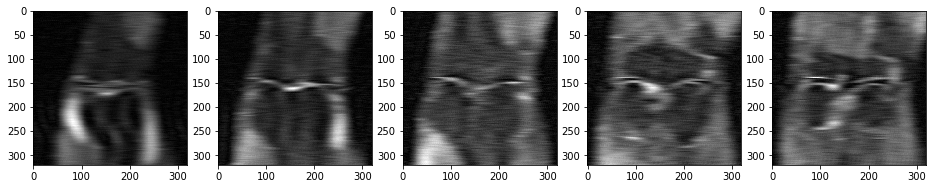

In [7]:
slice_num = [12, 16, 19, 22, 24]
show_slices(img_3d, slice_num, cmap='gray')

In [12]:
TEST_LOW_DIR = "singlecoil_train_3D_images_48x/low/"
H.create_directory("{}/{}".format(TEST_DATASET_PATH, TEST_LOW_DIR))

In [13]:
LOW_DIR_PATH = os.path.join(TRAIN_DATASET_PATH, LOW_DIR)
LOW_DIR_PATH

('E:\\FastMRI\\MRI-reconstruction\\dataset\\singlecoil_train_3D_images_48x/low/',
 'E:\\FastMRI\\MRI-reconstruction\\dataset\\singlecoil_train_3D_images_48x/high/')

In [14]:
len(train_h5_files)

973

In [15]:
i=0
for file in train_h5_files:
    i+=1
    
    hf = h5py.File(file)
    
    # transform and save low res image
    kspace_tensor = hf['kspace'][()]
    img_3d = sub_sample_kspace(kspace_tensor, mask_func) # 4x, 8x acceleration (NOW 4x8x acceleration)

    # Save X 
    np.save("{}/{}.npy".format(LOW_DIR_PATH, i), img_3d)

    
    # transform and save ground truth(RSS)
    gt_rss = hf['reconstruction_rss']
    img_3d_gt = recon_ground_truth(gt_rss)
    
    # Save Y
    np.save("{}/{}.npy".format(HIGH_DIR_PATH, i), img_3d_gt)
    
    # Show progress
    print(i, file[-15:], "raw data - ", kspace_tensor.shape, "--", "input volume - ", img_3d.shape, "--", "output volume - ", img_3d_gt.shape)

    

1 \file1000001.h5 raw data -  (36, 640, 372) -- input volume -  (36, 320, 320) -- output volume -  (36, 320, 320)
2 \file1000002.h5 raw data -  (38, 640, 368) -- input volume -  (38, 320, 320) -- output volume -  (38, 320, 320)
3 \file1000003.h5 raw data -  (45, 640, 368) -- input volume -  (45, 320, 320) -- output volume -  (45, 320, 320)
4 \file1000005.h5 raw data -  (35, 640, 372) -- input volume -  (35, 320, 320) -- output volume -  (35, 320, 320)
5 \file1000010.h5 raw data -  (36, 640, 368) -- input volume -  (36, 320, 320) -- output volume -  (36, 320, 320)
6 \file1000012.h5 raw data -  (32, 640, 372) -- input volume -  (32, 320, 320) -- output volume -  (32, 320, 320)
7 \file1000015.h5 raw data -  (36, 640, 372) -- input volume -  (36, 320, 320) -- output volume -  (36, 320, 320)
8 \file1000021.h5 raw data -  (35, 640, 368) -- input volume -  (35, 320, 320) -- output volume -  (35, 320, 320)
9 \file1000023.h5 raw data -  (34, 640, 368) -- input volume -  (34, 320, 320) -- output

### Sanity check

In [16]:
len(os.listdir(LOW_DIR_PATH)), len(os.listdir(HIGH_DIR_PATH))

(973, 973)

In [17]:
# remember to read data in same sequence to retain x,y mapping for each MRI scan
os.listdir(LOW_DIR_PATH)[:3], os.listdir(HIGH_DIR_PATH)[:3]

(['1.npy', '10.npy', '100.npy'], ['1.npy', '10.npy', '100.npy'])

In [18]:
print("Done!")

Done!
